In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, Trials, STATUS_OK, space_eval, hp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

%matplotlib inline

print "done"


done


In [2]:
#calling math csv into dataframe
df_math = pd.read_csv('data/student-mat.csv',delimiter = ';',header=0)
#lang
df_lang = pd.read_csv('data/student-por.csv',delimiter= ';',header=0)

#creating feature_data (X) and label data (y) for each df
#the cat dataframes do not have dummy variables b/c catboost has its own method for dealing with categoricals

#math
y_math = [1 if i >= 10 else 0 for i in df_math['G3']]
X_math_cat= df_math.drop(['G1','G2','G3'], axis = 1)
###


y_lang = [1 if i >= 10 else 0 for i in df_lang['G3']]
X_lang_cat= df_lang.drop(['G1','G2','G3'], axis = 1)
###
###creating math and lang df's with dummy variables for non_catboost models
X_math = pd.get_dummies(X_math_cat, drop_first = True)
###
X_lang = pd.get_dummies(X_lang_cat, drop_first = True)


#creating a class labels array for future use
y_math_labels = ['Pass' if i == 1  else 'Fail' for i in y_math]
y_lang_labels = ['Pass' if i == 1  else 'Fail' for i in y_lang ]
#creating A class names list for future use
class_names = ['Pass', 'Fail']

print "done"



done


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_math, y_math, test_size = 0.3,random_state = 16 ,stratify = y_math)

Test AUC = 0.6542


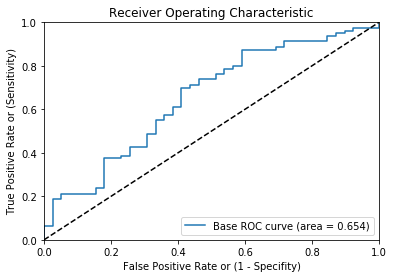

In [4]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)
auc_score_base = roc_auc_score(y_test, y_score[:,1])
fpr_base, tpr_base, _ = roc_curve(y_test,  y_score[:,1])
print('Test AUC = {:.4f}'.format(auc_score_base))


plt.plot(fpr_base, tpr_base, label='Base ROC curve (area = %0.3f)' % auc_score_base)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()





In [5]:
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

xgb_space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
     #   'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        # 'nthread': 4,
     #   'booster': 'gbtree',
    #    'tree_method': 'exact',
        'silent': 1,
        'seed': SEED
}

In [6]:
def g_mean(estimator, X, y):
    y_pred = estimator.predict(X)
    return geometric_mean_score(y, y_pred, pos_label=2)

def objective(params):
    shuffle = KFold(n_splits=5, shuffle=True)
#    print (X_train.shape, y_train.shape)
    score = cross_val_score(model, X_train, y_train, cv=shuffle, scoring=g_mean, n_jobs=1, verbose=3) # 'roc_auc'
    print score
    return 1-score.mean()

trials = Trials()
print trials

best = fmin(fn=objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

[CV]  ................................................................
[CV] ............................ , score=0.40138648596, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.573983766618, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.638442398069, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.414039335605, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.554700196225, total=   0.0s
[ 0.40138649  0.57398377  0.6384424   0.41403934  0.5547002 ]
[CV]  ................................................................
[CV] ........................... , score=0.540061724867, total=   0.0s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ............................ , score=0.60214043164, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.643920916217, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.355035801248, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.570155592256, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished



[ 0.54006172  0.60214043  0.64392092  0.3550358   0.57015559]
[CV]  ................................................................
[CV] ........................... , score=0.612372435696, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.527963677348, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.522349942439, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.505388916238, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.466849780924, total=   0.0s
[ 0.61237244  0.52796368  0.52234994  0.50538892  0.46684978]
[CV]  ................................................................
[CV] ........................... , score=0.543358164785, total=   0.0s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.461880215352, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.608434308444, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.588937048289, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.560112033611, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished



[ 0.54335816  0.46188022  0.60843431  0.58893705  0.56011203]
[CV]  ................................................................
[CV] ........................... , score=0.580947501931, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.508265022733, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.493995779576, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.503322295685, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.547722557505, total=   0.0s
[ 0.5809475   0.50826502  0.49399578  0.5033223   0.54772256]
[CV]  ................................................................
[CV] ........................... , score=0.657662774683, total=   0.0s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.610620293519, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.427490980035, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.635488909302, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.476330511622, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished



[ 0.65766277  0.61062029  0.42749098  0.63548891  0.47633051]
[CV]  ................................................................
[CV] ............................ , score=0.57735026919, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.336650164612, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.399724422978, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.411813845414, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.611010092661, total=   0.0s
[ 0.57735027  0.33665016  0.39972442  0.41181385  0.61101009]
[CV]  ................................................................
[CV] ........................... , score=0.522604267571, total=   0.0s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.438397299481, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.424264068712, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.621059003408, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.651134861751, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished



[ 0.52260427  0.4383973   0.42426407  0.621059    0.65113486]
[CV]  ................................................................
[CV] ........................... , score=0.361403161162, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.498535868013, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ........................... , score=0.545454545455, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.491689171894, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.580119351115, total=   0.1s
[ 0.36140316  0.49853587  0.54545455  0.49168917  0.58011935]
[CV]  ................................................................
[CV] ............................ , score=0.44280744277, total=   0.0s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  ................................................................
[CV] ............................ , score=0.63438081969, total=   0.0s
[CV]  ................................................................
[CV] ............................ , score=0.51987524491, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.539737460818, total=   0.0s
[CV]  ................................................................
[CV] ........................... , score=0.366679398811, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished



[ 0.44280744  0.63438082  0.51987524  0.53973746  0.3666794 ]


0.654166666667


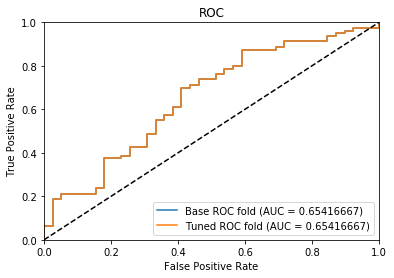

In [27]:
param_values = [x['misc']['vals'] for x in trials.trials]
param_values = [{key:value for key in x for value in x[key]} for x in param_values]
param_values = [space_eval(xgb_space, x) for x in param_values]

param_df = pd.DataFrame(param_values)
param_df['auc_score'] = [1 - x for x in trials.losses()]
param_df.index.name = 'Iteration'
param_df.to_csv("xgb_parameter_values.csv")


best_params = space_eval(xgb_space, best)


model.fit(X_train, y_train);

# Score with the test data
y_score = model.predict_proba(X_test)
auc_score_tuned = roc_auc_score(y_test, y_score[:,1])
print auc_score_tuned

fpr_tuned, tpr_tuned, _ = roc_curve(y_test,  y_score[:,1])


# Plot ROC curve
plt.plot(fpr_base, tpr_base, label='Base ROC fold (AUC = %0.8f)' % auc_score_base)
plt.plot(fpr_tuned, tpr_tuned, label='Tuned ROC fold (AUC = %0.8f)'% auc_score_tuned)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()